In [1]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torchvision

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# import os
# from py7zr import SevenZipFile

# # Ruta del archivo .7z en Google Drive
# archivo_7z_path = './drive/MyDrive/SIS421/Primer_Parcial/FastFood80x80.7z'

# # Directorio de extracción
# directorio_extraccion = './drive/MyDrive/SIS421/Primer_Parcial/'

# # Extraer el archivo .7z
# with SevenZipFile(archivo_7z_path, 'r') as archive:
#     archive.extractall(path=directorio_extraccion)

# # Listar los archivos extraídos
# archivos_extraidos = os.listdir(directorio_extraccion)
# print("Archivos extraídos:", archivos_extraidos)

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
from tqdm import tqdm
import numpy as np
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


In [5]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Ruta del directorio raíz
root = "./drive/MyDrive/SIS421/Primer_Parcial/FastFood80x80"

# Transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((80, 80)),  # Ajusta el tamaño a 80x80
    transforms.ToTensor(),         # Convierte a tensor
])

# Rutas para los conjuntos de datos
train_dir = root + "/Train"
test_dir = root + "/Test"
valid_dir = root + "/Valid"

# Crear conjuntos de datos
trainset = ImageFolder(root=train_dir, transform=transform)
testset = ImageFolder(root=test_dir, transform=transform)
validset = ImageFolder(root=valid_dir, transform=transform)

# Crear dataloaders
batch_size = 64
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(validset, batch_size=batch_size, shuffle=False)

# Clases
classes = trainset.classes

# Verificar el número de clases y muestras en cada conjunto
num_classes = len(classes)
num_train_samples = len(trainset)
num_test_samples = len(testset)
num_valid_samples = len(validset)

print("Número de clases:", num_classes)
print("Número de muestras de entrenamiento:", num_train_samples)
print("Número de muestras de prueba:", num_test_samples)
print("Número de muestras de validación:", num_valid_samples)

Número de clases: 10
Número de muestras de entrenamiento: 15000
Número de muestras de prueba: 1500
Número de muestras de validación: 3500


In [9]:

# Definición del modelo usando un modelo preentrenado (ResNet18)
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        # Cargar el modelo preentrenado
        self.resnet = models.resnet18(pretrained=True)

        # Modificar la última capa para adaptarse a la nueva tarea
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

# Crear la instancia del modelo
model = CustomCNN(num_classes)

# Mover el modelo al dispositivo (CPU o GPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Definir una función de pérdida y un optimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 135MB/s]


In [7]:
# Definición del modelo con 4 capas convolucionales y capas de pooling
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 5 * 5, 256)  # Adjust the input size based on the architecture
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))
        x = x.view(-1, 128 * 5 * 5)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Crear la instancia del modelo
model = CustomCNN(num_classes)

# Mover el modelo al dispositivo (CPU o GPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Definir una función de pérdida y un optimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [10]:
# Función para entrenar
def train(model, train_loader, valid_loader, optimizer, criterion, num_epochs=5, start_epoch=0):
    for epoch in range(start_epoch, num_epochs):
        model.train()
        train_loss, train_acc = [], []
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (outputs.argmax(dim=1) == labels).float().mean().item()
            train_acc.append(acc)

        model.eval()
        val_loss, val_acc = [], []
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss.append(loss.item())
                acc = (outputs.argmax(dim=1) == labels).float().mean().item()
                val_acc.append(acc)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {np.mean(train_loss):.5f}, Train Acc: {np.mean(train_acc):.5f}, "
              f"Val Loss: {np.mean(val_loss):.5f}, Val Acc: {np.mean(val_acc):.5f}")

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc
        }, f'checkpoint_epoch_{epoch}.pth')




In [12]:
# Entrenar el modelo
start_epoch = 0  # Epoca inicial
# Llama a la función de entrenamiento y pasa start_epoch para continuar desde la época guardada
train(model, train_loader, valid_loader, optimizer, criterion, num_epochs=5, start_epoch=start_epoch)

  3%|▎         | 7/235 [02:17<1:13:52, 19.44s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 235/235 [1:10:30<00:00, 18.00s/it]


Epoch 1/5, Train Loss: 1.17554, Train Acc: 0.62301, Val Loss: 1.20325, Val Acc: 0.63097


100%|██████████| 235/235 [00:34<00:00,  6.72it/s]


Epoch 2/5, Train Loss: 0.75644, Train Acc: 0.76148, Val Loss: 1.55007, Val Acc: 0.57025


100%|██████████| 235/235 [00:34<00:00,  6.79it/s]


Epoch 3/5, Train Loss: 0.56256, Train Acc: 0.82114, Val Loss: 1.34982, Val Acc: 0.61981


100%|██████████| 235/235 [00:35<00:00,  6.69it/s]


Epoch 4/5, Train Loss: 0.42398, Train Acc: 0.86487, Val Loss: 1.93249, Val Acc: 0.54959


100%|██████████| 235/235 [00:34<00:00,  6.72it/s]


Epoch 5/5, Train Loss: 0.32126, Train Acc: 0.89661, Val Loss: 1.74695, Val Acc: 0.60209


In [ ]:
# Cargar el estado del modelo y del optimizador
# checkpoint = torch.load('checkpoint.pth')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# start_epoch = checkpoint['epoch'] + 1  # Empezar desde la siguiente época
# train_loss = checkpoint['train_loss']
# train_acc = checkpoint['train_acc']
# val_loss = checkpoint['val_loss']
# val_acc = checkpoint['val_acc']

In [14]:
# Entrenar el modelo inicialmente y guardar el progreso
train(model, train_loader, valid_loader, optimizer, criterion, num_epochs=5)

# Después, si deseas continuar el entrenamiento desde la época 6
start_epoch = 6
train(model, train_loader, valid_loader, optimizer, criterion, num_epochs=10, start_epoch=start_epoch)


100%|██████████| 235/235 [00:34<00:00,  6.72it/s]


Epoch 1/5, Train Loss: 0.23606, Train Acc: 0.92212, Val Loss: 1.26967, Val Acc: 0.70181


100%|██████████| 235/235 [00:35<00:00,  6.60it/s]


Epoch 2/5, Train Loss: 0.15812, Train Acc: 0.94832, Val Loss: 1.37493, Val Acc: 0.69447


100%|██████████| 235/235 [00:35<00:00,  6.66it/s]


Epoch 3/5, Train Loss: 0.17283, Train Acc: 0.94335, Val Loss: 1.47987, Val Acc: 0.67549


100%|██████████| 235/235 [00:34<00:00,  6.72it/s]


Epoch 4/5, Train Loss: 0.11303, Train Acc: 0.96308, Val Loss: 1.48420, Val Acc: 0.65289


100%|██████████| 235/235 [00:35<00:00,  6.64it/s]


Epoch 5/5, Train Loss: 0.12406, Train Acc: 0.95838, Val Loss: 1.44916, Val Acc: 0.68642


100%|██████████| 235/235 [00:35<00:00,  6.71it/s]


Epoch 7/10, Train Loss: 0.09912, Train Acc: 0.96944, Val Loss: 1.44205, Val Acc: 0.69223


100%|██████████| 235/235 [00:34<00:00,  6.71it/s]


Epoch 8/10, Train Loss: 0.09086, Train Acc: 0.97043, Val Loss: 1.57447, Val Acc: 0.66260


100%|██████████| 235/235 [00:34<00:00,  6.84it/s]


Epoch 9/10, Train Loss: 0.08638, Train Acc: 0.97185, Val Loss: 1.53587, Val Acc: 0.69695


100%|██████████| 235/235 [00:34<00:00,  6.75it/s]


Epoch 10/10, Train Loss: 0.10497, Train Acc: 0.96660, Val Loss: 1.62265, Val Acc: 0.66748


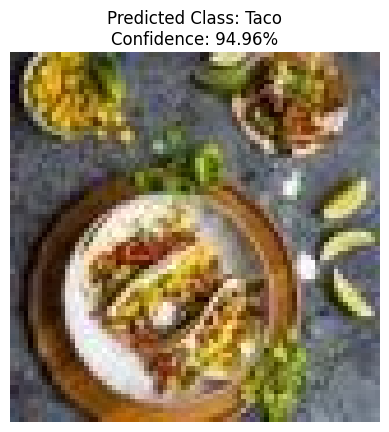

In [62]:
import matplotlib.pyplot as plt
import random

# Obtener una muestra aleatoria del conjunto de prueba
random_index = random.randint(0, len(testset) - 1)
sample_image, sample_label = testset[random_index]
sample_image = sample_image.unsqueeze(0).to(device)  # Agregar dimensión de lote y mover a dispositivo

# Obtener la predicción para la muestra
model.eval()
with torch.no_grad():
    output = model(sample_image)

# Obtener el porcentaje de confianza
probabilities = torch.softmax(output, dim=1)
confidence_percentage = torch.max(probabilities) * 100
predicted_class = torch.argmax(probabilities).item()
predicted_class_name = classes[predicted_class]

# Mostrar la imagen y el porcentaje de confianza
plt.imshow(sample_image.squeeze().permute(1, 2, 0).cpu().numpy())
plt.title(f'Predicted Class: {predicted_class_name}\nConfidence: {confidence_percentage:.2f}%')
plt.axis('off')
plt.show()